In [13]:
import torch

import tr_util
import util
from Dimploma.EnvironmentTree import EnvInfo, MatrixEnvInfo
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from Dimploma.utils.my_agent_base import RandomAgent, OptimalAgent
from Dimploma.utils.testingResult import TestResult
from Dimploma.zNetwork.hybrid_gcn import HybridNetworkGlobal
from Dimploma.zNetwork.my_gcn import GCN
from Dimploma.zNetwork.fully_con import FCN

In [2]:
%load_ext autoreload
%autoreload 2

In [35]:
default_path = 'results/min_tree_ppo/node/'
# default_path = 'results/min_tree_ppo/node_cuda/'
# agent_path = '250401_1745#n10_e33_g42_ma_no_ma_2-2_64env_coef'
agent_path = '250404_1314#n10_e33_g42_g'
agent_print_name = 'grafova'
# agent_print_name = 'Náš agent'
testing_path = f'{default_path}{agent_path}'

maximal = False


compare = True
compare_default_path = 'results/min_tree_ppo/node/'
# compare_default_path = 'results/min_tree_ppo/node_cuda/'
compare_agent_path = '250403_1841#n10_e33_g42_mn_4-2_no_heur2'
compare_print_name = 'Plna'
# compare_print_name = 'Porovnávací agent'
compare_testing_path = f'{compare_default_path}{compare_agent_path}'

tr_util.load_desc(testing_path)
if compare:
    print('----------------------------------------')
    tr_util.load_desc(compare_testing_path)


Training comment:
Trying to train a graph agent with similar parameters as the matrix one


Trying out training with:

Training
Iterations: 1000
Epochs: 4
Batch size: 576
Steps amount: 18
Count of processes: 16
Count of envs: 4
On device: cuda
without early stopping


Network:
Main layers: 3
P layers: 2
V layers: 2
without catenation between layers

Environment:
Class: EnvMinimalTreeTwoStep
Loaded graph from graphs/graph42_n10_e33_heur_rew2.pt
Graph representation
Node amount: 10
Edge amount: 33
Node features: 2
When graph representation is used
With indexes in nodes

When matrix representation is used
Observation consistt of:

Selected edge info
Selected node info


Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.002
Gae_lambda: 0.95
Learning rate: 0.0025

----------------------------------------

Training comment:
Trying to test out matrix repr with fully connected layers

-no longer using heuristic rewards


Trying out training with:

Training
Iterations: 1000


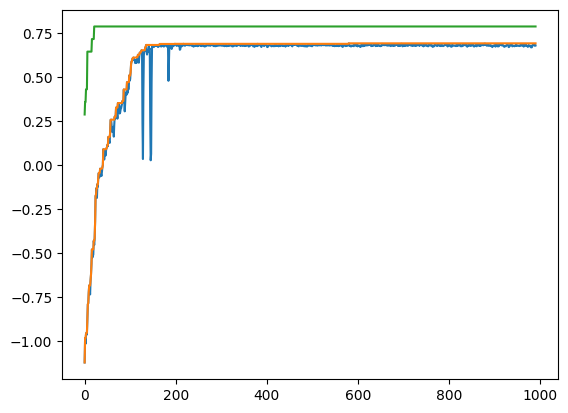

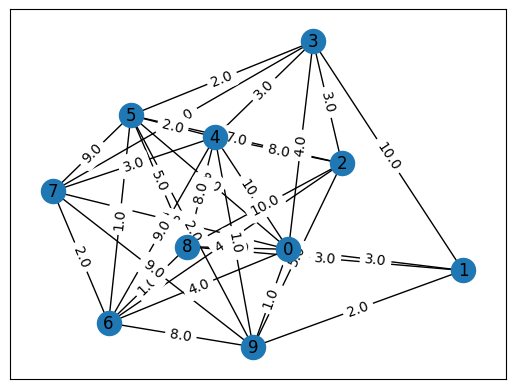

Loading model from results/min_tree_ppo/node/250403_1841#n10_e33_g42_mn_4-2_no_heur2/models/iter_999_last.pt


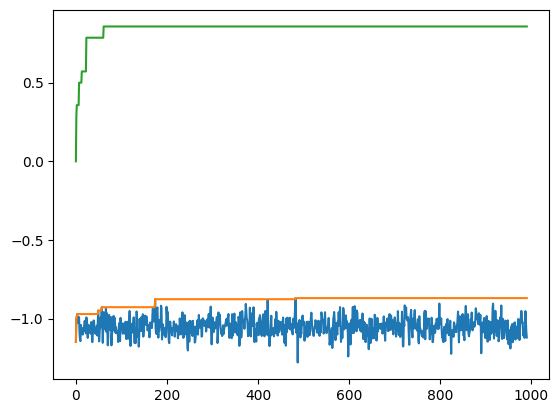

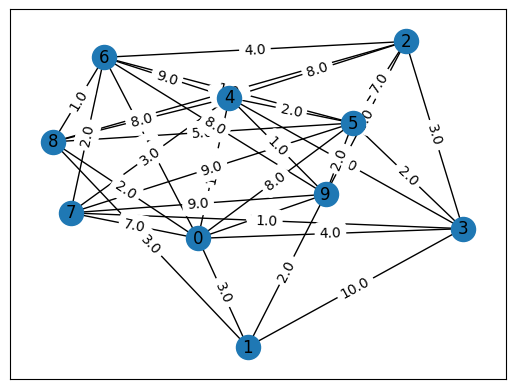

Loading model from results/min_tree_ppo/node/250404_1314#n10_e33_g42_g/models/iter_999_last.pt


In [36]:

node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = 33

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
iteration_amount = 1000

# Main agent
main_hybrid = False
main_full = False
edge_info = True
node_info = True
step_info = False
adj_matrix = False
main_edge_dim = None
random_edge_dim = None
node_features = 2  # (index, {0,1} selected or not)
main_layers = 3
main_p_layers = 2
main_v_layers = 2
position = False
remove_index = False
if position:
    node_features += 2
if remove_index:
    node_features -= 1

if main_hybrid:
    main_gcn = HybridNetworkGlobal(node_features, node_amount, remove_index=remove_index, position=position)
    random_gcn = HybridNetworkGlobal(node_features, node_amount, remove_index=remove_index, position=position)
elif main_full:
    main_gcn = FCN(node_amount, node_features, edge_amount, main_layers, main_p_layers, main_v_layers, edge_info, node_info, step_info, adj_matrix)
    random_gcn = FCN(node_amount, node_features, edge_amount, main_layers, main_p_layers, main_v_layers, edge_info, node_info, step_info, adj_matrix)
else:
    main_gcn = GCN(node_amount, node_features, cat=False, conv_layers=main_layers, conv_p_layers=main_p_layers, linear_layers=main_v_layers, remove_index=remove_index, position=position, edge_dim=main_edge_dim)
    random_gcn = GCN(node_amount, node_features, cat=False, conv_layers=main_layers, conv_p_layers=main_p_layers, linear_layers=main_v_layers, remove_index=remove_index, position=position, edge_dim=random_edge_dim)



graph_provider = GraphProvider(fixed_graph=None, device=device, nodes=node_amount, edges=edge_amount, position=position)

env_info = EnvInfo(graph_provider)
if main_full:
    env_info = MatrixEnvInfo(graph_provider, edge_info, node_info, step_info, adj_matrix)

# Comparing agent
if compare:
    compare_special = True

    compare_hybrid = False
    compare_full = True
    compare_node_features = 2  # (index, {0,1} selected or not)
    compare_position = False
    compare_remove_index = False
    compare_edge_info = True
    compare_node_info = True
    compare_step_info = False
    compare_adj_matrix = False
    compare_edge_dim = None
    compare_layers = 4
    compare_p_layers = 2
    compare_v_layers = 2
    if compare_position:
        compare_node_features += 2
    if compare_remove_index:
        compare_node_features -= 1

    compare_env_info = env_info
    if compare_special:
        if compare_full:
            compare_env_info = MatrixEnvInfo(graph_provider, compare_edge_info, compare_node_info, compare_step_info, compare_adj_matrix)
        else:
            compare_env_info = EnvInfo(graph_provider)

    if compare_hybrid:
        compare_gcn = HybridNetworkGlobal(compare_node_features, node_amount, remove_index=compare_remove_index, position=compare_position)
    elif compare_full:
        compare_gcn = FCN(node_amount, node_features, edge_amount, compare_layers, compare_p_layers, compare_v_layers, edge_info, node_info, step_info, adj_matrix)
    else:
        compare_gcn = GCN(node_amount, compare_node_features, cat=False, conv_layers=compare_layers, conv_p_layers=compare_p_layers, linear_layers=compare_v_layers, remove_index=compare_remove_index, position=compare_position, edge_dim=compare_edge_dim)
    compare_graph, compare_test_env, compare_agent_test = tr_util.load_agent_for_testing(compare_testing_path, iteration_amount, compare_env_info, compare_gcn, device)



loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(testing_path, iteration_amount, env_info, main_gcn, device, maximal)

In [46]:
test_amount = 100
pretty_print = True
print_rews = False

tests = TestResult(node_amount, test_amount)

#random agents
random_uniform = RandomAgent()

random_net = Agent(model=random_gcn, device=device, name="random_test", override=True, test=True)

tests.addAgent(agent_print_name, agent_test, 'orange')
if compare:
    # noinspection PyUnboundLocalVariable
    tests.addAgent(compare_print_name, compare_agent_test, 'yellow', special=compare_special)
tests.addAgent('Optimum' if pretty_print else 'Optimal', OptimalAgent(), 'green')
tests.addAgent('Náhodný výber' if pretty_print else 'Random uniform', random_uniform, 'red', multiple_tetst=True)
tests.addAgent('Náhodná sieť' if pretty_print else 'Random network', random_net)


grafova
Priemer, Min, Max: 42.00
Plna
Priemer, Min, Max: 18.00
Optimum
Priemer, Min, Max: 14.00
Náhodný výber
Priemer: 42.96, Min: 21.00, Max: 67.00
Náhodná sieť
Priemer, Min, Max: 46.00


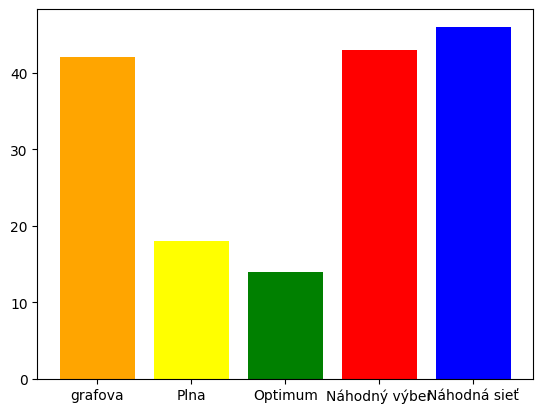

In [47]:
tests.setup()
tests.test(test_env)
if compare_special:
    # noinspection PyUnboundLocalVariable
    tests.test(compare_test_env, special=True)

if pretty_print:
    tests.print_result_pretty()
else:
    tests.print_result(print_rews)
# print(f'Optimal: {test_env.calculate_min_span_tree()}')

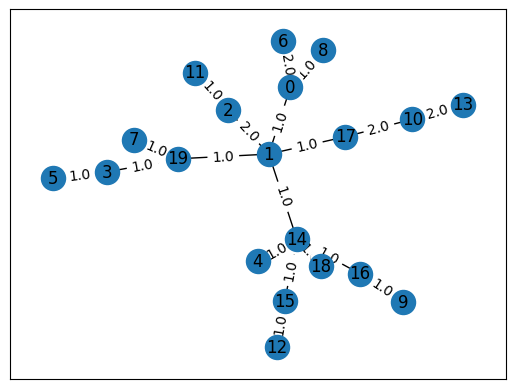

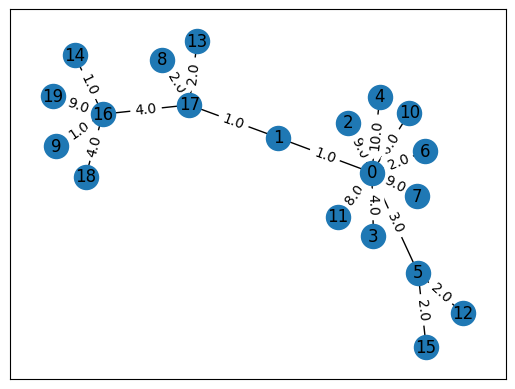

(tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]),
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1.4782608695652173],
 [17,
  1,
  17,
  13,
  8,
  17,
  0,
  1,
  0,
  5,
  0,
  2,
  16,
  17,
  0,
  3,
  0,
  4,
  0,
  6,
  0,
  7,
  16,
  9,
  0,
  10,
  16,
  14,

In [18]:
_, a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [94]:
node_sums = util.get_node_sums(loaded_graph)
degrees = util.get_out_edges(loaded_graph)

print(f'Node sum max: {node_sums.max()}')
print(f'Node sum min: {node_sums.min()}')
print(f'Degree max: {degrees.max()}')
print(f'Degree min: {degrees.min()}')

torch.stack([loaded_graph.x[:, 0], node_sums.T, degrees.T])

Node sum max: 10.300000190734863
Node sum min: 5.5
Degree max: 18.0
Degree min: 10.0


tensor([[ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
          8.0000,  9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000,
         16.0000, 17.0000, 18.0000, 19.0000],
        [ 8.9000,  7.7000,  9.5000,  7.3000,  6.8000,  7.3000,  6.4000, 10.3000,
          6.9000,  8.8000,  9.7000,  6.3000,  7.6000,  6.8000,  6.7000,  7.4000,
          5.5000,  7.8000,  8.1000,  6.6000],
        [15.0000, 16.0000, 17.0000, 14.0000, 11.0000, 14.0000, 12.0000, 17.0000,
         12.0000, 14.0000, 18.0000, 14.0000, 14.0000, 13.0000, 16.0000, 13.0000,
         10.0000, 16.0000, 14.0000, 14.0000]])

In [ ]:
torch.cat([loaded_graph.edge_index.T, loaded_graph.edge_attr], dim=1)

In [12]:
loaded_graph.edge_attr[:, :2].shape

torch.Size([33, 2])